In [1]:
# [Cell 2] 라이브러리 임포트 및 GPU 확인
import ultralytics
from ultralytics import YOLO
import torch
import os
from IPython.display import Image, display

# GPU 사용 가능 여부 확인
print(f"Ultralytics version: {ultralytics.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:a
    print("Using CPU (Training X-large model on CPU is not recommended!)")

Ultralytics version: 8.3.234
Torch version: 2.1.2+cu121
CUDA available: True
Using GPU: Tesla V100-SXM2-32GB


In [3]:
import json
import os
import shutil
import numpy as np
from tqdm import tqdm
from collections import Counter, defaultdict

# 설정
CLASSES = [
    "General trash", "Paper", "Paper pack", "Metal", "Glass",
    "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"
]

ROOT_DIR = "/data/ephemeral/home/dataset"
JSON_PATH = os.path.join(ROOT_DIR, "new_train.json")
OUTPUT_DIR = "/data/ephemeral/home/yolo_dataset"
VAL_RATIO = 0.15

# 초기화
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
for split in ['train', 'val']:
    os.makedirs(os.path.join(OUTPUT_DIR, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'labels', split), exist_ok=True)

# 데이터 로드 및 Class 정보 파싱 (Size 제거됨)
print(f"Loading {JSON_PATH}...")
with open(JSON_PATH, 'r') as f:
    data = json.load(f)

images = data['images']
annotations = data['annotations']

# ID 매핑
img_id_to_info = {img['id']: img for img in images}
img_to_anns = defaultdict(list)

# 이미지별 포함된 클래스 리스트
img_to_classes = defaultdict(list)

print("Pre-processing: Parsing Class info...")

for ann in annotations:
    img_id = ann['image_id']
    cat_id = ann['category_id']
    
    img_to_classes[img_id].append(cat_id)
    img_to_anns[img_id].append(ann)

# 3terative Stratification
def run_iterative_class_aware():
    print("Running Iterative Stratification (Class Only)...")
    
    # 전체 클래스 등장 빈도 계산
    class_counts = Counter()
    for img_id in img_to_classes:
        class_counts.update(img_to_classes[img_id])
        
    # 희귀한 클래스를 포함한 이미지 우선 처리
    sorted_ids = sorted([img['id'] for img in images],
        key=lambda x: min([class_counts[c] for c in img_to_classes[x]]) if img_to_classes[x] else float('inf'))

    val_ids = []
    
    # 현재까지 배정된 개수 추적
    train_counts_curr = defaultdict(int)
    val_counts_curr = defaultdict(int)
    
    for img_id in tqdm(sorted_ids):
        cats = img_to_classes[img_id] # [0, 1, 5, ...]
        
        # 어노테이션 없으면 건너뜀 (나중에 Train으로 처리)
        if not cats: continue
        
        score = 0
        for cat in cats:
            # 해당 클래스의 현재 Validation 비율 확인
            v = val_counts_curr[cat]
            t = train_counts_curr[cat]
            curr_total = v + t + 1 # 0 division 방지
            curr_ratio = v / curr_total
            
            # 목표 비율보다 부족하면 Validation으로 보내야 한다고 투표
            if curr_ratio < VAL_RATIO: score += 1
            else: score -= 1
        
        # 투표 결과가 양수면 Validation으로 할당
        if score > 0:
            val_ids.append(img_id)
            for c in cats: val_counts_curr[c] += 1
        else:
            for c in cats: train_counts_curr[c] += 1
            
    return val_ids

# 실행
val_ids_list = run_iterative_class_aware()
val_ids_set = set(val_ids_list)

print(f"Split Result -> Train: {len(images) - len(val_ids_set)}, Val: {len(val_ids_set)}")

# 파일 변환 및 이동
print("Converting and moving files...")

count_success = 0
count_fail = 0

for img_id in tqdm([img['id'] for img in images]):
    img_info = img_id_to_info[img_id]
    file_name = img_info['file_name']
    img_w = img_info['width']
    img_h = img_info['height']
    
    path_a = os.path.join(ROOT_DIR, file_name)
    path_b = os.path.join(ROOT_DIR, 'train', os.path.basename(file_name))
    
    if os.path.exists(path_a): src_img_path = path_a
    elif os.path.exists(path_b): src_img_path = path_b
    else:
        count_fail += 1
        continue

    split = 'val' if img_id in val_ids_set else 'train'
    
    # 이미지 링크 (Symlink)
    dst_filename = os.path.basename(file_name)
    dst_img_path = os.path.join(OUTPUT_DIR, 'images', split, dst_filename)
    if not os.path.exists(dst_img_path):
        os.symlink(src_img_path, dst_img_path)
    
    # 라벨 파일 생성 (YOLO Format)
    label_file_name = os.path.splitext(dst_filename)[0] + ".txt"
    dst_label_path = os.path.join(OUTPUT_DIR, 'labels', split, label_file_name)
    
    with open(dst_label_path, 'w') as f:
        anns = img_to_anns[img_id]
        for ann in anns:
            cat_id = ann['category_id']
            bbox = ann['bbox']
            x_min, y_min, w, h = bbox
            
            # Normalize (0~1)
            x_center = (x_min + w / 2) / img_w
            y_center = (y_min + h / 2) / img_h
            w_norm = w / img_w
            h_norm = h / img_h
            
            x_center = max(0, min(1, x_center))
            y_center = max(0, min(1, y_center))
            w_norm = max(0, min(1, w_norm))
            h_norm = max(0, min(1, h_norm))
            
            f.write(f"{cat_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")
            
    count_success += 1

print(f"\n성공: {count_success}, 실패: {count_fail}")
print(f"데이터셋 저장 위치: {OUTPUT_DIR}")

# 검증
print("\n[검증] Class Distribution Check (Val Set):")
val_counts = np.zeros(len(CLASSES))
train_counts = np.zeros(len(CLASSES))

for img_id in images:
    # 해당 이미지에 포함된 클래스 리스트 가져오기
    cats = img_to_classes[img_id['id']]
    
    if img_id['id'] in val_ids_set:
        for cat_id in cats:
            val_counts[cat_id] += 1
    else:
        for cat_id in cats:
            train_counts[cat_id] += 1

print(f"{'Class':<15} | {'Count':<6} | {'Val Ratio'}")
print("-" * 50)
for i, cls_name in enumerate(CLASSES):
    v_cnt = val_counts[i]
    t_cnt = train_counts[i]
    total = v_cnt + t_cnt
    ratio = (v_cnt / total * 100) if total > 0 else 0
    print(f"{cls_name:<15} | {int(v_cnt):<6} | {ratio:.2f}%")

Loading /data/ephemeral/home/dataset/new_train.json...


FileNotFoundError: [Errno 2] No such file or directory: '/data/ephemeral/home/dataset/new_train.json'

📊 Counting labels from generated dataset...

Dataset Summary (Greedy Iterative Stratification)
Images  : Original=4883, Train=4171, Val=712
Objects : Original=23632, Train=20068, Val=3564
           Class  Orig(%)  Train(%)  Val(%)  Diff(Orig-Val)
0  General trash    18.28     18.28   18.29           -0.01
1          Paper    27.00     27.02   26.85            0.15
2     Paper pack     3.86      3.86    3.87           -0.01
3          Metal     4.11      4.12    4.10            0.02
4          Glass     4.14      4.15    4.12            0.02
5        Plastic    12.62     12.64   12.54            0.08
6      Styrofoam     5.30      5.26    5.50           -0.20
7    Plastic bag    21.86     21.87   21.77            0.08
8        Battery     0.68      0.65    0.81           -0.14
9       Clothing     2.15      2.15    2.13            0.01
Tip: 'Diff(Orig-Val)'이 0에 가까울수록 원본 분포를 잘 유지한 것입니다.

📈 그래프가 저장되었습니다: /data/ephemeral/home/yolo_dataset/distribution_check_greedy.png


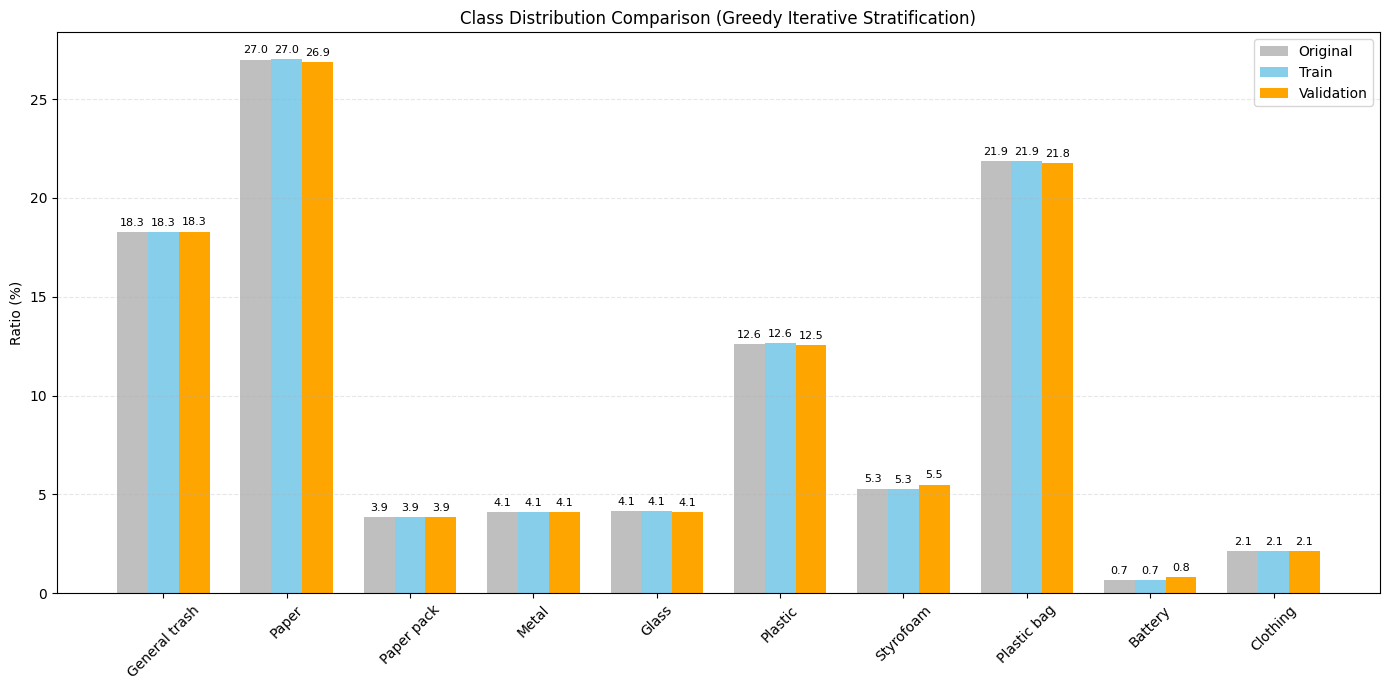

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 설정
DATA_DIR = "/data/ephemeral/home/yolo_dataset"
CLASSES = [
    "General trash", "Paper", "Paper pack", "Metal", "Glass",
    "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"
]

def count_classes(split_name):
    label_dir = os.path.join(DATA_DIR, 'labels', split_name)
    # 폴더가 없을 경우 대비
    if not os.path.exists(label_dir):
        print(f"Warning: {label_dir} not found.")
        return np.zeros(len(CLASSES), dtype=int), 0

    label_files = glob.glob(os.path.join(label_dir, "*.txt"))
    counts = np.zeros(len(CLASSES), dtype=int)
    
    for file_path in label_files:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if not parts: continue
                try:
                    class_id = int(parts[0])
                    if 0 <= class_id < len(CLASSES):
                        counts[class_id] += 1
                except ValueError:
                    continue
    return counts, len(label_files)

# 데이터 집계
print("Counting labels from generated dataset...")
train_counts, train_img_cnt = count_classes('train')
val_counts, val_img_cnt = count_classes('val')

# Original은 Train + Val 합산
orig_counts = train_counts + val_counts
orig_img_cnt = train_img_cnt + val_img_cnt

# 총 객체 수 (분모)
train_total = train_counts.sum()
val_total = val_counts.sum()
orig_total = orig_counts.sum()

# 비율 계산 (%)
# 0으로 나누기 방지
train_ratios = (train_counts / train_total * 100) if train_total > 0 else np.zeros(len(CLASSES))
val_ratios = (val_counts / val_total * 100) if val_total > 0 else np.zeros(len(CLASSES))
orig_ratios = (orig_counts / orig_total * 100) if orig_total > 0 else np.zeros(len(CLASSES))

# 텍스트 결과 (DataFrame)
df = pd.DataFrame({
    'Class': CLASSES,
    'Orig(%)': orig_ratios.round(2),
    'Train(%)': train_ratios.round(2),
    'Val(%)': val_ratios.round(2),
    'Diff(Orig-Val)': (orig_ratios - val_ratios).round(2) # 원본과 검증셋의 차이 (중요)
})

print("\n" + "="*80)
print(f"Dataset Summary (Greedy Iterative Stratification)")
print(f"Images  : Original={orig_img_cnt}, Train={train_img_cnt}, Val={val_img_cnt}")
print(f"Objects : Original={orig_total}, Train={train_total}, Val={val_total}")
print("="*80)
print(df)
print("="*80)
print("Tip: 'Diff(Orig-Val)'이 0에 가까울수록 원본 분포를 잘 유지한 것입니다.")

# 그래프 그리기 (Bar Chart)
x = np.arange(len(CLASSES))  
width = 0.25  # 막대 너비

fig, ax = plt.subplots(figsize=(14, 7))

# 막대 3개 배치 (Orig, Train, Val)
rects1 = ax.bar(x - width, orig_ratios, width, label='Original', color='gray', alpha=0.5)
rects2 = ax.bar(x, train_ratios, width, label='Train', color='skyblue')
rects3 = ax.bar(x + width, val_ratios, width, label='Validation', color='orange')

# 데코레이션
ax.set_ylabel('Ratio (%)')
ax.set_title('Class Distribution Comparison (Greedy Iterative Stratification)')
ax.set_xticks(x)
ax.set_xticklabels(CLASSES, rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

# 값 표시 함수
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()

# 이미지 저장
save_path = os.path.join(DATA_DIR, 'distribution_check_greedy.png')
plt.savefig(save_path)
print(f"\n그래프가 저장되었습니다: {save_path}")
plt.show()

In [5]:
yaml_content = f"""
path: {OUTPUT_DIR}
train: images/train
val: images/val
test:  # test 이미지는 라벨이 없으므로 생략

nc: {len(CLASSES)}
names: {CLASSES}
"""

with open("trash.yaml", "w") as f:
    f.write(yaml_content)

print("trash.yaml created!")

✅ trash.yaml created!


In [6]:
from ultralytics import YOLO
import wandb

batch = 4
lr0 = 5e-5
epochs=50
imgsz=1024

# 모델 로드
model = YOLO('yolo12x.pt') 

# 학습 시작
results = model.train(
    data='trash.yaml',   # 위에서 만든 yaml 파일
    epochs=epochs,           # 기존 Faster R-CNN 설정과 비슷하게 (필요시 늘리세요)
    imgsz=imgsz,           # 기존 설정에 맞춰 512 (메모리 여유 있으면 640, 1024 추천)
    batch=batch,             # X 모델은 무거우므로 OOM 발생 시 2로 줄이세요 4-> 16
    device=[0],          # GPU 번호
    
    project='yolo12x',         # WandB의 'Project' 이름
    name=f"yolo12x_batch{batch}_lr{lr0}_epochs{epochs}_imgsz{imgsz}_Iterative_Stratification_new", # 실험(Run) 이름
    
    exist_ok=True,       # 덮어쓰기 허용
    
    optimizer='AdamW',   #
    lr0=lr0,            # 초기 학습률
    cos_lr=True,
    dropout=0.1,
    weight_decay=0.0005,
    patience=7,           # 7 epoch 동안 성능 향상 없으면 조기 종료
)

print("🎉 Training Finished!")

New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.10.13 torch-2.1.2+cu121 CUDA:0 (Tesla V100-SXM2-32GB, 32501MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=trash.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=5e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12x_batch4_lr5e-05_epochs50_imgsz1024_Iter

wandb: Currently logged in as: 0129jonsu (cv_12) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytic

wandb: WARNING Tried to log to step 50 that is less than the current step 51. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


lr/pg0,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆█████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
lr/pg2,▃▆██████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
metrics/mAP50(B),▁▃▃▄▅▅▆▆▇▇▇▆▇▇▇▇▇▇▇██▇█▇██▇█████████████
metrics/mAP50-95(B),▁▃▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
metrics/precision(B),▁▂▁▂▃▆▄▄▅▆▅▇▆▆▆▆▆▆▆▆▇▇▇█▇▇█▇▇▇█▇▆█▇██▇██
metrics/recall(B),▁▂▃▅▄▅▅▆▆▆▆▇▇▆▆▇▇▆▇█▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇█▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


🎉 Training Finished!


In [7]:
import torch
import gc

# 메모리를 많이 차지하는 주요 변수 삭제
try:
    del model
    del results
    print("변수 삭제 완료.")
except NameError:
    print("이미 삭제되었거나 존재하지 않는 변수입니다.")

# 가비지 컬렉션 (참조가 끊긴 메모리 수거)
gc.collect()

# CUDA 캐시 비우기 (핵심 명령어)
torch.cuda.empty_cache()

# 현재 메모리 상태 확인
if torch.cuda.is_available():
    print(f"현재 할당된 메모리: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print("GPU 메모리 정리가 완료되었습니다.")

변수 삭제 완료.
현재 할당된 메모리: 0.03 GB
✅ GPU 메모리 정리가 완료되었습니다.


In [1]:
import os
import json
import pandas as pd
from ultralytics import YOLO
from tqdm import tqdm

# Settings
ROOT_DIR = "/data/ephemeral/home/dataset"
TEST_JSON = os.path.join(ROOT_DIR, "test.json")

TEST_IMG_DIR = os.path.join(ROOT_DIR, "test") 

MODEL_PATH = "/data/ephemeral/home/yolo12x/yolo8x_batch4_lr5e-05_epochs50_imgsz1024_Iterative_Stratification_new/weights/best.pt"

CLASSES = [
    "General trash", "Paper", "Paper pack", "Metal", "Glass",
    "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"
]


# Load Model
print(f"Loading model from {MODEL_PATH}...")
model = YOLO(MODEL_PATH)

# Load Test Metadata
with open(TEST_JSON, 'r') as f:
    test_data = json.load(f)

prediction_strings = []
file_names = []

print("Starting Inference...")

# ==========================
# 4. Inference Loop
# ==========================
for img_info in tqdm(test_data['images']):
    # img_info['file_name'] typically looks like 'test/0000.jpg' or '0000.jpg'
    file_name = img_info['file_name']
    
    # Construct the full path to the image
    # If file_name already contains 'test/', use ROOT_DIR, otherwise use TEST_IMG_DIR
    if 'test/' in file_name:
        img_path = os.path.join(ROOT_DIR, file_name)
    else:
        img_path = os.path.join(TEST_IMG_DIR, file_name)
    
    # Run YOLO inference
    # conf=0.001: Keep low confidence boxes for better mAP (standard for competitions)
    # iou=0.6: NMS threshold
    # imgsz=512: Match your training image size
    results = model.predict(
        source=img_path, 
        conf=0.01,
        iou=0.6,         
        imgsz=1024,
        augment=True, ######################
        verbose=False,
    )
    
    result = results[0]
    prediction_string = ""
    
    # Parse results
    if result.boxes:
        boxes = result.boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
        confs = result.boxes.conf.cpu().numpy()  # Confidence Score
        cls_ids = result.boxes.cls.cpu().numpy() # Class ID
        
        temp_preds = []
        for box, conf, cls_id in zip(boxes, confs, cls_ids):
            x1, y1, x2, y2 = box
            label = int(cls_id)
            
            # Submission Format: Label Score x1 y1 x2 y2 ...
            temp_preds.append(f"{label} {conf:.6f} {x1:.2f} {y1:.2f} {x2:.2f} {y2:.2f}")
            
        prediction_string = " ".join(temp_preds)
    
    prediction_strings.append(prediction_string)
    
    # Explicitly format image_id as 'test/XXXX.jpg'
    # This handles cases where img_info['id'] is an int (0) or string ('0000')
    image_id_str = str(img_info['id'])
    
    # If it's just a number like '0', convert to 'test/0000.jpg'
    if '/' not in image_id_str:
        try:
            formatted_id = f"test/{int(image_id_str):04d}.jpg"
        except ValueError:
            # Fallback if id is not a number (unlikely for COCO format)
            formatted_id = f"test/{image_id_str}.jpg"
    else:
        # If it's already 'test/0000.jpg', keep it
        formatted_id = image_id_str
        
    file_names.append(formatted_id)

# ==========================
# 5. Save to CSV
# ==========================
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names 

save_path = "./output_yolo12x.csv"
submission.to_csv(save_path, index=False)

print(f"Submission saved to {save_path}")
print(submission.head())

Loading model from /data/ephemeral/home/yolo12x/yolo8x_batch4_lr5e-05_epochs50_imgsz1024_Iterative_Stratification_new/weights/best.pt...
Starting Inference...


100%|██████████████████████████████████████████████████████████████████| 4871/4871 [14:39<00:00,  5.54it/s]


✅ Submission saved to ./output_yolo12x.csv
                                    PredictionString       image_id
0  7 0.984750 603.68 516.28 956.23 1021.94 7 0.97...  test/0000.jpg
1  5 0.952818 132.72 0.46 493.32 268.30 4 0.84257...  test/0001.jpg
2  1 0.971311 75.75 271.27 426.74 602.16 4 0.9538...  test/0002.jpg
3  9 0.976229 145.17 261.57 913.49 825.28 9 0.482...  test/0003.jpg
4  1 0.978934 194.14 253.72 872.32 779.91 0 0.498...  test/0004.jpg


In [2]:
import pandas as pd
import os

# 원본 CSV 파일 경로
INPUT_CSV_PATH = "output_yolov12x.csv"
# 변환 후 저장할 새로운 CSV 파일 경로
OUTPUT_CSV_PATH = "submission_formatted.csv"

# ==========================
# 2. 변환 로직
# ==========================
if not os.path.exists(INPUT_CSV_PATH):
    # 파일이 없으면 baseline 폴더 등 다른 경로 확인 (필요시 수정)
    possible_path = "/data/ephemeral/home/baseline/output_yolo12x.csv"
    if os.path.exists(possible_path):
        INPUT_CSV_PATH = possible_path
    else:
        print(f"Error: '{INPUT_CSV_PATH}' 파일을 찾을 수 없습니다.")
        exit()

print(f"Loading: {INPUT_CSV_PATH}")
df = pd.read_csv(INPUT_CSV_PATH)

# 변환 전 샘플 출력
print(f"Before:\n{df['image_id'].head(3)}") 

# 숫자를 받아서 'test/0000.jpg' 형태로 변경
def format_image_id(val):
    try:
        # 이미 'test/'가 포함된 문자열이면 그대로 반환
        val_str = str(val)
        if 'test/' in val_str:
            return val_str
        
        # 숫자라면 정수로 변환 후 4자리 패딩하여 포맷팅
        return f"test/{int(val):04d}.jpg"
    except ValueError:
        # 변환 실패 시 원본 유지
        return val

# 함수 적용 (Apply)
df['image_id'] = df['image_id'].apply(format_image_id)

# ==========================
# 3. 저장 및 확인
# ==========================
df.to_csv(OUTPUT_CSV_PATH, index=False)

print("-" * 30)
print(f"변환 완료! 저장 경로: {OUTPUT_CSV_PATH}")
print("-" * 30)
print(f"After:\n{df['image_id'].head(3)}")

🚨 Error: 'output_yolov8x.csv' 파일을 찾을 수 없습니다.
📂 Loading: output_yolov8x.csv


FileNotFoundError: [Errno 2] No such file or directory: 'output_yolov8x.csv'